In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import warnings
warnings.filterwarnings('ignore')

import re
import jax.numpy as jnp
from jax import grad, jit, partial
import ticktack
from ticktack import fitting
from tqdm import tqdm
import scipy

rcParams['figure.figsize'] = (8.0, 4.0)

In [2]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
cf = fitting.CarbonFitter(cbm)
cf.load_data('inject_recovery_sine_noise.csv')
cf.prepare_function(use_control_points=True, interp='gp')

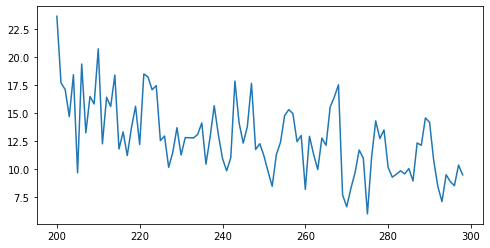

In [3]:
plt.plot(cf.time_data, cf.d14c_data)

In [4]:
@jit
def sine(t):
    prod =  1.87 + 0.18 * 1.87 * jnp.sin(2 * jnp.pi / 11 * t + jnp.pi/2)
    prod = prod * (t>=cf.start) + (1.87 + 0.18 * 1.87 * jnp.sin(2 * jnp.pi / 11 * cf.start + jnp.pi/2)) * (1-(t>=cf.start))
    return prod

In [5]:
params = jnp.array([2.00931194, 1.76726608, 1.63956763, 1.55857636, 1.56151923,
       1.66039248, 1.82542414, 2.00902505, 2.1499783 , 2.20236607,
       2.14934031, 2.00726453, 1.82035463, 1.64890761, 1.5466909 ,
       1.54656586, 1.64925724, 1.82132598, 2.00889662, 2.15182241,
       2.20535925, 2.15200561, 2.00854828, 1.82123595, 1.64888389,
       1.54646122, 1.54698844, 1.64984516, 1.82230742, 2.01012623,
       2.15341134, 2.20693235, 2.15341037, 2.00972495, 1.82173407,
       1.64883591, 1.54591849, 1.5460004 , 1.64787559, 1.82050195,
       2.00797563, 2.15125214, 2.20426493, 2.15096213, 2.00745209,
       1.81993238, 1.64752185, 1.54486673, 1.54527152, 1.64771486,
       1.8206848 , 2.00867882, 2.15243267, 2.20596917, 2.15285339,
       2.00991348, 1.82234807, 1.64996723, 1.54776168, 1.54789426,
       1.65037576, 1.82302573, 2.01059753, 2.15370878, 2.20688716,
       2.1530896 , 2.00909437, 1.82097974, 1.64761549, 1.54446511,
       1.54388179, 1.64604148, 1.81797455, 2.00576724, 2.14926194,
       2.20312077, 2.15059049, 2.00818758, 1.82193644, 1.65088141,
       1.54970386, 1.55087782, 1.6539408 , 1.82596808, 2.01229156,
       2.15310531, 2.20305982, 2.14595439, 1.99987839, 1.8116132 ,
       1.64273006, 1.54857759, 1.56085616, 1.67526338, 1.84984877,
       2.01559762, 2.09159252, 2.04924512])

In [6]:
import inspect
print(inspect.getsource(cf.interp_gp))

    @partial(jit, static_argnums=(0,))
    def interp_gp(self, tval, *args):
        tval = tval.reshape(-1)
        params = jnp.squeeze(jnp.array(list(args)))
        control_points = params
        mean = params[0]

        kernel = jax_terms.Matern32Term(sigma=2., rho=2.)
        gp = celerite2.jax.GaussianProcess(kernel, mean=mean)
        gp.compute(self.control_points_time)
        mu = gp.predict(control_points, t=tval, return_var=False)
        mu = (tval > self.start) * mu +  (tval <= self.start) * mean
        return mu



In [7]:
sine(200)

DeviceArray(2.00982869, dtype=float64)

In [8]:
cf.offset

DeviceArray(18.29674076, dtype=float64)

In [9]:
cf.offset = 0
cf.offset

0

In [10]:
%%time
soln = cf.fit_cp(low_bound=0.)

CPU times: user 12min 2s, sys: 5.45 s, total: 12min 7s
Wall time: 10min 40s


In [11]:
soln.message

'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'

In [12]:
print("total likelihood: ", cf.gp_likelihood(soln.x))
print("gp likelihood: ", cf.gp_neg_log_likelihood(soln.x))
print("chi2: ", cf.loss_chi2(soln.x))

total likelihood:  135.13229673306313
gp likelihood:  108.48687762838333
chi2:  26.64541910467979


Text(0.5, 1.0, 'gauss production rate')

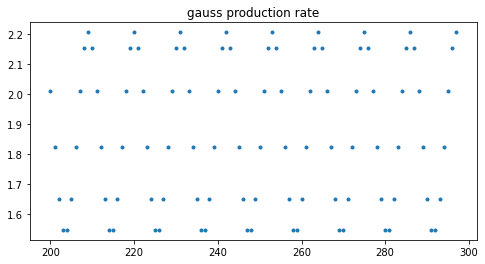

In [13]:
t = cf.control_points_time
true_cp = sine(t)
plt.plot(t, sine(t), ".")
plt.title('gauss production rate')

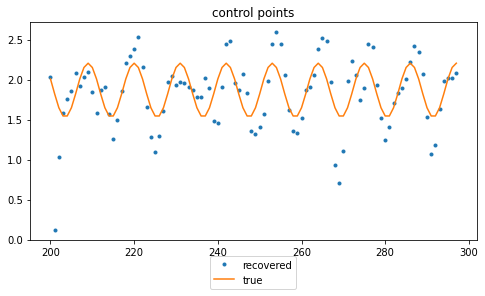

In [14]:
plt.plot(t, soln.x, ".", label="recovered")
plt.plot(t, true_cp, label='true')
plt.title("control points");
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True)

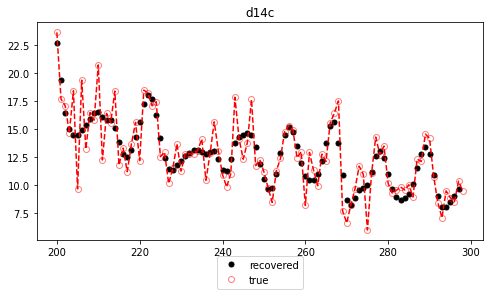

In [15]:
plt.plot(cf.time_data[:-1], cf.dc14(soln.x), ".k", label="recovered", markersize=10)
plt.plot(cf.time_data, cf.d14c_data, '--r')
plt.plot(cf.time_data, cf.d14c_data, 'or', fillstyle="none", label="true", alpha=0.5)
plt.title("d14c");
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True)

In [16]:
soln.x

array([2.03586531, 0.12095901, 1.03951556, 1.58912698, 1.75579824,
       1.85416495, 2.08470323, 1.92255504, 2.03265161, 2.09506909,
       1.84849857, 1.58162355, 1.87463792, 1.91266609, 1.57412793,
       1.26040389, 1.49709067, 1.86252336, 2.21056692, 2.30017391,
       2.38086124, 2.53521152, 2.15546246, 1.65505222, 1.2835534 ,
       1.09565469, 1.2910131 , 1.60725948, 1.97119015, 2.0484668 ,
       1.93240398, 1.96964811, 1.95592144, 1.91073676, 1.87729876,
       1.77876636, 1.78690423, 2.02601386, 1.89884511, 1.48463047,
       1.46024112, 1.90368045, 2.45046095, 2.4808794 , 1.96219941,
       1.87014251, 2.06895589, 1.83691985, 1.35329752, 1.32502814,
       1.41280741, 1.57641756, 1.98655975, 2.44461477, 2.59216122,
       2.45061687, 2.06081681, 1.61784283, 1.35457333, 1.33156994,
       1.52304596, 1.87678582, 1.90705735, 2.06271466, 2.38276965,
       2.52103007, 2.48048331, 1.96816663, 0.9339802 , 0.71135062,
       1.10783608, 1.98268233, 2.22895746, 2.05535107, 1.75275

In [17]:
t = np.arange(cf.start-10, cf.start+10, 0.1)

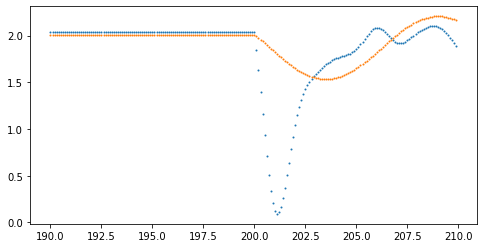

In [18]:
mu = cf.production(t, (soln.x,))
plt.plot(t, mu, ".", markersize=2)
plt.plot(t, sine(t), ".", markersize=2)

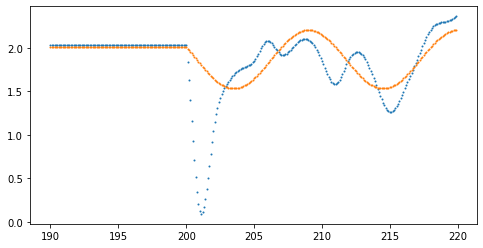

In [19]:
t = np.arange(cf.start-10, cf.start+20, 0.1)
mu = cf.production(t, (soln.x,))
plt.plot(t, mu, ".", markersize=2)
plt.plot(t, sine(t), ".", markersize=2)

In [20]:
params = soln.x

In [21]:
def diagnostic(t):
    cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
    cf = fitting.CarbonFitter(cbm)
    cf.load_data('inject_recovery_gp.csv')
    cf.prepare_function(use_control_points=True, interp='gp')
    
    burn_in = cf.run(cf.burn_in_time, cf.steady_state_y0, params=params)
    data, solution = cf.cbm.run(t, production=cf.production, args=params, y0=burn_in[-1,:])
    d_14_c = cf.cbm._to_d14c(data, cf.steady_state_y0)

    plt.plot(t, d_14_c, ".", label='fitted')
    plt.legend()

    cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
    cf2 = fitting.CarbonFitter(cbm)
    cf2.load_data('inject_recovery_gp.csv')
    cf2.prepare_function(custom_function=True, f=sine)

    burn_in_true = cf2.run(cf2.burn_in_time, cf2.steady_state_y0)
    data_true, solution_true = cf2.cbm.run(t, production=cf2.production, y0=burn_in_true[-1,:])
    d_14_c_true = cf2.cbm._to_d14c(data_true, cf2.steady_state_y0)

    plt.plot(t, d_14_c_true, ".", label='true')
    plt.legend()

In [22]:
t = np.arange(cf.start-1000, cf.start-10, 0.1)
t1 = np.arange(cf.start-20, cf.start+0.01, 0.1)

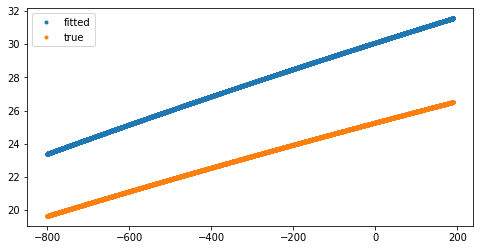

In [23]:
diagnostic(t)